In [1]:
!pip -q install pandas numpy matplotlib tqdm scikit-learn nltk rank-bm25 sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:0000:0100:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [4]:
import os, re, math, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words("english"))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer


In [5]:
DATA_PATH = "/kaggle/input/medquad-medical-question-answer-for-ai-research/medquad.csv"  

df_raw = pd.read_csv(DATA_PATH)

required_cols = {"question","answer","source","focus_area"}
missing = required_cols - set(df_raw.columns)
assert not missing, f"❌ Missing columns: {missing}. Required: {required_cols}"

print("✅ Loaded:", df_raw.shape)
df_raw.head()


✅ Loaded: (16412, 4)


,question,answer,source,focus_area
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma


In [6]:
print("Null values per column:")
print(df_raw.isnull().sum())

print("\nNull percentage:")
print((df_raw.isnull().sum() / len(df_raw) * 100).round(3))

empty_counts = {}
for col in ["question","answer","source","focus_area"]:
    empty_counts[col] = (df_raw[col].astype(str).str.strip() == "").sum()

print("\nEmpty/blank strings per column:")
print(pd.Series(empty_counts))


Null values per column:
question       0
answer         5
source         0
focus_area    14
dtype: int64

Null percentage:
question      0.000
answer        0.030
source        0.000
focus_area    0.085
dtype: float64

Empty/blank strings per column:
question      0
answer        0
source        0
focus_area    0
dtype: int64


In [7]:
df = df_raw.copy()

# Convert blanks -> NA for consistency
df.replace(r"^\s*$", pd.NA, regex=True, inplace=True)

# Drop rows missing core content
before = len(df)
df = df.dropna(subset=["question","answer"])
after = len(df)
print(f"Dropped {before-after} rows with missing question/answer")

# Fill missing metadata
df["source"] = df["source"].fillna("unknown")
df["focus_area"] = df["focus_area"].fillna("general")

# Ensure string type
for c in ["question","answer","source","focus_area"]:
    df[c] = df[c].astype(str)

df.isnull().sum()


Dropped 5 rows with missing question/answer


question      0
answer        0
source        0
focus_area    0
dtype: int64

In [8]:
dup_q = df.duplicated(subset=["question"]).sum()
dup_qa = df.duplicated(subset=["question","answer"]).sum()
print("Duplicate questions:", dup_q)
print("Duplicate QA pairs:", dup_qa)

before = len(df)
df = df.drop_duplicates(subset=["question","answer"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before-after} duplicates")


Duplicate questions: 1428
Duplicate QA pairs: 48
Removed 48 duplicates


In [9]:
def clean_text(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"\s+", " ", x).strip()
    x = re.sub(r"[^a-z0-9\s\.\,\?\!\-\%/]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def tokenize(text: str):
    toks = word_tokenize(text)
    return [t for t in toks if t not in STOPWORDS and len(t) > 2]

df["question_clean"] = df["question"].apply(clean_text)
df["answer_clean"]   = df["answer"].apply(clean_text)

# Docs for retrieval
df["doc_q"]  = df["question_clean"]
df["doc_qa"] = df["question_clean"] + " " + df["answer_clean"]

# length features
df["q_len"] = df["question_clean"].apply(lambda x: len(x.split()))
df["a_len"] = df["answer_clean"].apply(lambda x: len(x.split()))

df.head()


,question,answer,source,focus_area,question_clean,answer_clean,doc_q,doc_qa,q_len,a_len
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,what is are glaucoma ?,glaucoma is a group of diseases that can damag...,what is are glaucoma ?,what is are glaucoma ? glaucoma is a group of ...,5,323
1,What causes Glaucoma ?,"Nearly 2.7 million people have glaucoma, a lea...",NIHSeniorHealth,Glaucoma,what causes glaucoma ?,"nearly 2.7 million people have glaucoma, a lea...",what causes glaucoma ?,what causes glaucoma ? nearly 2.7 million peop...,4,200
2,What are the symptoms of Glaucoma ?,Symptoms of Glaucoma Glaucoma can develop in ...,NIHSeniorHealth,Glaucoma,what are the symptoms of glaucoma ?,symptoms of glaucoma glaucoma can develop in o...,what are the symptoms of glaucoma ?,what are the symptoms of glaucoma ? symptoms o...,7,269
3,What are the treatments for Glaucoma ?,"Although open-angle glaucoma cannot be cured, ...",NIHSeniorHealth,Glaucoma,what are the treatments for glaucoma ?,"although open-angle glaucoma cannot be cured, ...",what are the treatments for glaucoma ?,what are the treatments for glaucoma ? althoug...,7,314
4,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...,NIHSeniorHealth,Glaucoma,what is are glaucoma ?,glaucoma is a group of diseases that can damag...,what is are glaucoma ?,what is are glaucoma ? glaucoma is a group of ...,5,112


In [10]:
before = len(df)
df = df[(df["q_len"] >= 3) & (df["a_len"] >= 5)].reset_index(drop=True)
after = len(df)
print(f"Removed {before-after} short/noisy rows")
print("Final dataset shape:", df.shape)


Removed 6 short/noisy rows
Final dataset shape: (16353, 10)


In [11]:
print("Final shape:", df.shape)
print("Unique focus_area:", df["focus_area"].nunique())
print("Unique source:", df["source"].nunique())
print("\nQuestion length summary:\n", df["q_len"].describe())
print("\nAnswer length summary:\n", df["a_len"].describe())


Final shape: (16353, 10)
Unique focus_area: 5126
Unique source: 9

Question length summary:
 count    16353.000000
mean         8.237999
std          2.387663
min          3.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         27.000000
Name: q_len, dtype: float64

Answer length summary:
 count    16353.000000
mean       201.625390
std        248.313315
min          5.000000
25%         71.000000
50%        139.000000
75%        252.000000
max       4301.000000
Name: a_len, dtype: float64


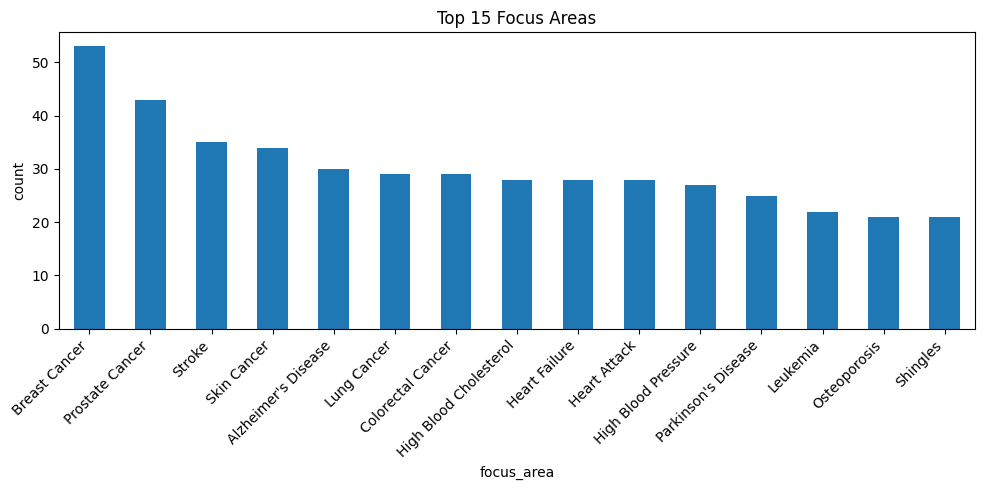

In [12]:
focus_counts = df["focus_area"].value_counts().head(15)

plt.figure(figsize=(10,5))
focus_counts.plot(kind="bar")
plt.title("Top 15 Focus Areas")
plt.xlabel("focus_area")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


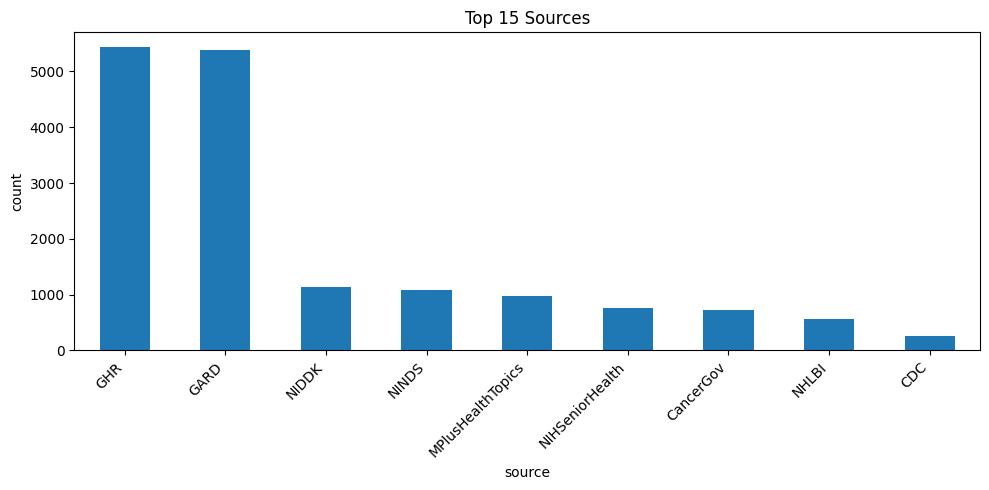

In [13]:
source_counts = df["source"].value_counts().head(15)

plt.figure(figsize=(10,5))
source_counts.plot(kind="bar")
plt.title("Top 15 Sources")
plt.xlabel("source")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


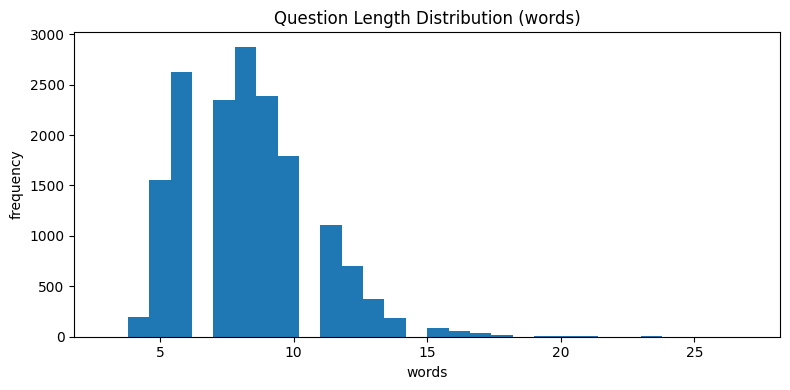

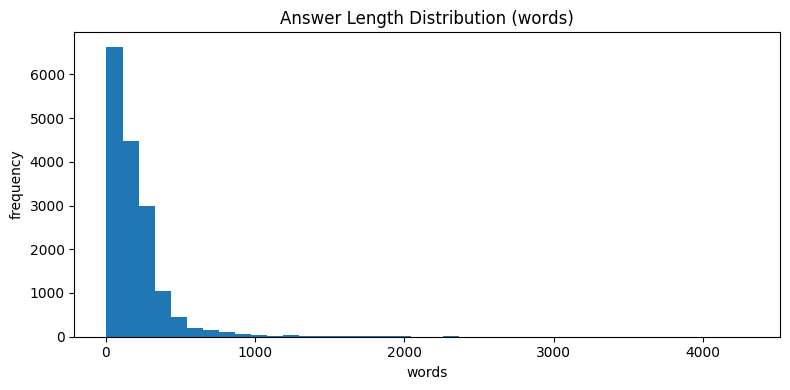

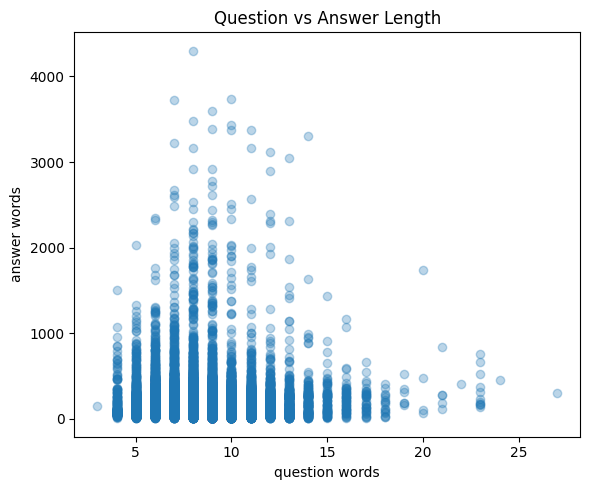

In [14]:
plt.figure(figsize=(8,4))
plt.hist(df["q_len"], bins=30)
plt.title("Question Length Distribution (words)")
plt.xlabel("words")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(df["a_len"], bins=40)
plt.title("Answer Length Distribution (words)")
plt.xlabel("words")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df["q_len"], df["a_len"], alpha=0.3)
plt.title("Question vs Answer Length")
plt.xlabel("question words")
plt.ylabel("answer words")
plt.tight_layout()
plt.show()


In [15]:
class TfidfSearch:
    def __init__(self, use_qa_text=True, max_features=50000, ngram_range=(1,2)):
        self.use_qa_text = use_qa_text
        self.vectorizer = TfidfVectorizer(
            stop_words="english",
            max_features=max_features,
            ngram_range=ngram_range
        )
        self.doc_matrix = None

    def fit(self, df):
        docs = df["doc_qa"] if self.use_qa_text else df["doc_q"]
        self.doc_matrix = self.vectorizer.fit_transform(docs)

    def search(self, query, top_k=10):
        q = clean_text(query)
        q_vec = self.vectorizer.transform([q])
        scores = cosine_similarity(q_vec, self.doc_matrix).flatten()
        idx = np.argsort(scores)[::-1][:top_k]
        return [(int(i), float(scores[i])) for i in idx]

tfidf = TfidfSearch(use_qa_text=True)
tfidf.fit(df)
print("✅ TF-IDF ready")


✅ TF-IDF ready


In [16]:
class BM25Search:
    def __init__(self):
        self.bm25 = None
        self.tokenized_docs = None

    def fit(self, df):
        self.tokenized_docs = [tokenize(x) for x in df["doc_q"].tolist()]
        self.bm25 = BM25Okapi(self.tokenized_docs)

    def search(self, query, top_k=10):
        q = tokenize(clean_text(query))
        scores = np.array(self.bm25.get_scores(q), dtype=float)
        idx = np.argsort(scores)[::-1][:top_k]
        return [(int(i), float(scores[i])) for i in idx]

    def all_scores(self, query):
        q = tokenize(clean_text(query))
        return np.array(self.bm25.get_scores(q), dtype=float)

bm25 = BM25Search()
bm25.fit(df)
print("✅ BM25 ready")


✅ BM25 ready


In [17]:
SBERT_MODEL = "all-MiniLM-L6-v2"

sbert_model = SentenceTransformer(SBERT_MODEL)

doc_emb = sbert_model.encode(
    df["doc_q"].tolist(),
    convert_to_numpy=True,
    normalize_embeddings=True,
    batch_size=128,
    show_progress_bar=True
).astype(np.float32)

class SBERTSearch:
    def __init__(self, model, doc_embeddings):
        self.model = model
        self.doc_emb = doc_embeddings

    def search(self, query, top_k=10):
        q = clean_text(query)
        q_emb = self.model.encode([q], convert_to_numpy=True, normalize_embeddings=True)[0].astype(np.float32)
        scores = np.dot(self.doc_emb, q_emb)
        idx = np.argsort(scores)[::-1][:top_k]
        return [(int(i), float(scores[i])) for i in idx]

    def all_scores(self, query):
        q = clean_text(query)
        q_emb = self.model.encode([q], convert_to_numpy=True, normalize_embeddings=True)[0].astype(np.float32)
        return np.dot(self.doc_emb, q_emb)

sbert = SBERTSearch(sbert_model, doc_emb)
print("✅ SBERT ready:", SBERT_MODEL)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/128 [00:00<?, ?it/s]

✅ SBERT ready: all-MiniLM-L6-v2


In [18]:
def minmax_norm(x: np.ndarray) -> np.ndarray:
    x = np.array(x, dtype=float)
    if x.max() == x.min():
        return np.ones_like(x)
    return (x - x.min()) / (x.max() - x.min())

class HybridSearch:
    def __init__(self, bm25_engine, sbert_engine, alpha=0.4):
        self.bm25 = bm25_engine
        self.sbert = sbert_engine
        self.alpha = alpha

    def search(self, query, top_k=10):
        bm25_scores = self.bm25.all_scores(query)
        sbert_scores = self.sbert.all_scores(query)

        bm25_n = minmax_norm(bm25_scores)
        sbert_n = minmax_norm(sbert_scores)

        fused = self.alpha * bm25_n + (1 - self.alpha) * sbert_n
        idx = np.argsort(fused)[::-1][:top_k]
        return [(int(i), float(fused[i])) for i in idx]

hybrid = HybridSearch(bm25, sbert, alpha=0.4)
print("✅ Hybrid ready (alpha=0.4)")


✅ Hybrid ready (alpha=0.4)


In [19]:
def show_results(title, results, n=5):
    print("\n" + "="*90)
    print(title)
    print("="*90)
    for rank, (i, s) in enumerate(results[:n], start=1):
        row = df.iloc[i]
        print(f"\n{rank}. score={s:.4f}")
        print("Q:", row["question"])
        print("A:", row["answer"][:260] + ("..." if len(row["answer"]) > 260 else ""))
        print("source:", row["source"])
        print("focus_area:", row["focus_area"])

q = "What are symptoms of diabetes?"
show_results("TF-IDF", tfidf.search(q, 10))
show_results("BM25", bm25.search(q, 10))
show_results("SBERT", sbert.search(q, 10))
show_results("HYBRID", hybrid.search(q, 10))



TF-IDF

1. score=0.3873
Q: What are the symptoms of Diabetes mellitus type 1 ?
A: What are the signs and symptoms of Diabetes mellitus type 1? The Human Phenotype Ontology provides the following list of signs and symptoms for Diabetes mellitus type 1. If the information is available, the table below includes how often the symptom is seen in...
source: GARD
focus_area: Diabetes mellitus type 1

2. score=0.2973
Q: What is (are) Diabetes ?
A: Too Much Glucose in the Blood Diabetes means your blood glucose (often called blood sugar) is too high. Your blood always has some glucose in it because your body needs glucose for energy to keep you going. But too much glucose in the blood isn't good for your...
source: NIHSeniorHealth
focus_area: Diabetes

3. score=0.2892
Q: What are the symptoms of Your Guide to Diabetes: Type 1 and Type 2 ?
A: The signs and symptoms of diabetes are
                
- being very thirsty  - urinating often  - feeling very hungry  - feeling very tired  - losing wei

In [21]:
focus_to_ids = df.groupby("focus_area").apply(lambda x: x.index.tolist()).to_dict()

def relevant_set(doc_id: int):
    fa = df.loc[doc_id, "focus_area"]
    return set(focus_to_ids.get(fa, []))


/tmp/ipykernel_47/3820910474.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  focus_to_ids = df.groupby("focus_area").apply(lambda x: x.index.tolist()).to_dict()


In [22]:
def precision_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    hits = sum(1 for d in retrieved_k if d in relevant)
    return hits / k

def recall_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    hits = sum(1 for d in retrieved_k if d in relevant)
    return hits / max(1, len(relevant))

def ndcg_at_k(retrieved, relevant, k):
    retrieved_k = retrieved[:k]
    rels = [1 if d in relevant else 0 for d in retrieved_k]
    dcg = sum((2**rel - 1) / math.log2(i + 2) for i, rel in enumerate(rels))
    ideal_rels = sorted(rels, reverse=True)
    idcg = sum((2**rel - 1) / math.log2(i + 2) for i, rel in enumerate(ideal_rels))
    return dcg / idcg if idcg > 0 else 0.0

def mrr_at_k(retrieved, relevant, k):
    for rank, d in enumerate(retrieved[:k], start=1):
        if d in relevant:
            return 1.0 / rank
    return 0.0

def evaluate_engine(search_fn, k=10, n=800, seed=42):
    sample = df.sample(min(n, len(df)), random_state=seed)
    P, R, NDCG, MRR = [], [], [], []

    for doc_id, row in sample.iterrows():
        query = row["question_clean"]
        results = search_fn(query, k)
        retrieved = [i for i, _ in results]
        rel = relevant_set(doc_id)

        P.append(precision_at_k(retrieved, rel, k))
        R.append(recall_at_k(retrieved, rel, k))
        NDCG.append(ndcg_at_k(retrieved, rel, k))
        MRR.append(mrr_at_k(retrieved, rel, k))

    return {
        f"P@{k}": float(np.mean(P)),
        f"R@{k}": float(np.mean(R)),
        f"nDCG@{k}": float(np.mean(NDCG)),
        f"MRR@{k}": float(np.mean(MRR)),
    }


In [23]:
k_eval = 10
n_eval = min(1000, len(df))

metrics = {
    "TF-IDF": evaluate_engine(lambda q, k: tfidf.search(q, k), k=k_eval, n=n_eval),
    "BM25":   evaluate_engine(lambda q, k: bm25.search(q, k),  k=k_eval, n=n_eval),
    "SBERT":  evaluate_engine(lambda q, k: sbert.search(q, k), k=k_eval, n=n_eval),
    "HYBRID": evaluate_engine(lambda q, k: hybrid.search(q, k),k=k_eval, n=n_eval),
}

results_df = pd.DataFrame(metrics).T
results_df


,P@10,R@10,nDCG@10,MRR@10
TF-IDF,0.4394,0.855990,0.875098,0.858593
BM25,0.4766,0.914368,0.938738,0.939437
SBERT,0.4414,0.865933,0.943855,0.984750
HYBRID,0.4828,0.927209,0.962173,0.982250


In [24]:
alphas = np.round(np.arange(0.0, 1.01, 0.05), 2)
tune_rows = []

for a in alphas:
    h = HybridSearch(bm25, sbert, alpha=float(a))
    m = evaluate_engine(lambda q, k: h.search(q, k), k=k_eval, n=n_eval, seed=42)
    m["alpha"] = float(a)
    tune_rows.append(m)

alpha_df = pd.DataFrame(tune_rows).sort_values(by=f"nDCG@{k_eval}", ascending=False).reset_index(drop=True)
alpha_df.head(10)


,P@10,R@10,nDCG@10,MRR@10,alpha
0,0.4814,0.922582,0.963629,0.982083,0.70
1,0.4836,0.926383,0.963251,0.982417,0.60
2,0.4812,0.921842,0.962960,0.980750,0.75
3,0.4834,0.926526,0.962888,0.983083,0.50
4,0.4836,0.927049,0.962696,0.983250,0.55
5,0.4823,0.924715,0.962586,0.979917,0.65
6,0.4828,0.927209,0.962173,0.982250,0.40
7,0.4806,0.920648,0.961292,0.978917,0.85
8,0.4804,0.920587,0.961221,0.977583,0.80
9,0.4820,0.926574,0.961051,0.982083,0.35


✅ Best alpha (BM25 weight) = 0.70


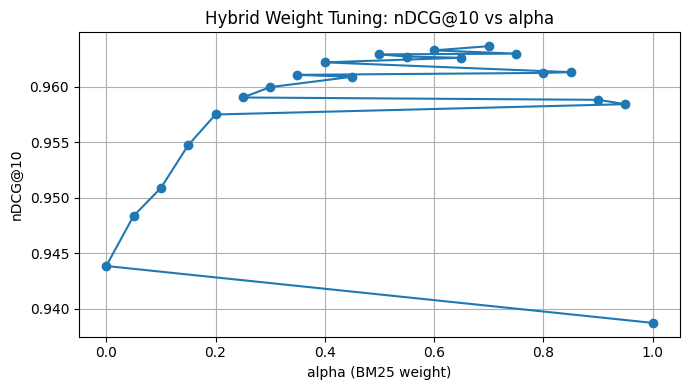

✅ Hybrid locked to best alpha: 0.7


In [25]:
best_alpha = float(alpha_df.iloc[0]["alpha"])
print(f"✅ Best alpha (BM25 weight) = {best_alpha:.2f}")

plt.figure(figsize=(7,4))
plt.plot(alpha_df["alpha"], alpha_df[f"nDCG@{k_eval}"], marker="o")
plt.title(f"Hybrid Weight Tuning: nDCG@{k_eval} vs alpha")
plt.xlabel("alpha (BM25 weight)")
plt.ylabel(f"nDCG@{k_eval}")
plt.grid(True)
plt.tight_layout()
plt.show()

hybrid = HybridSearch(bm25, sbert, alpha=best_alpha)
print("✅ Hybrid locked to best alpha:", best_alpha)


In [26]:
final_metrics = {
    "TF-IDF": evaluate_engine(lambda q, k: tfidf.search(q, k), k=k_eval, n=n_eval),
    "BM25":   evaluate_engine(lambda q, k: bm25.search(q, k),  k=k_eval, n=n_eval),
    "SBERT":  evaluate_engine(lambda q, k: sbert.search(q, k), k=k_eval, n=n_eval),
    "HYBRID (tuned)": evaluate_engine(lambda q, k: hybrid.search(q, k), k=k_eval, n=n_eval),
}
final_results_df = pd.DataFrame(final_metrics).T
final_results_df


,P@10,R@10,nDCG@10,MRR@10
TF-IDF,0.4394,0.855990,0.875098,0.858593
BM25,0.4766,0.914368,0.938738,0.939437
SBERT,0.4414,0.865933,0.943855,0.984750
HYBRID (tuned),0.4814,0.922582,0.963629,0.982083


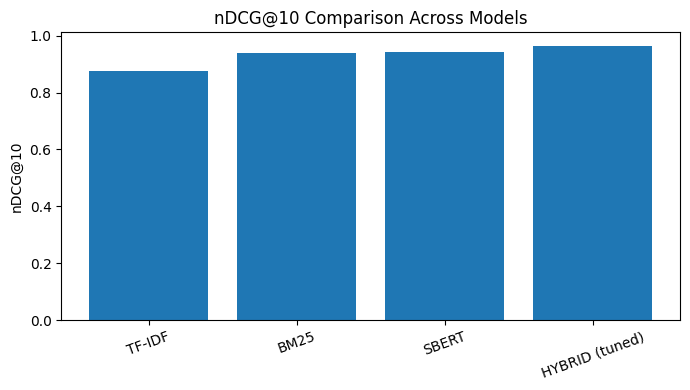

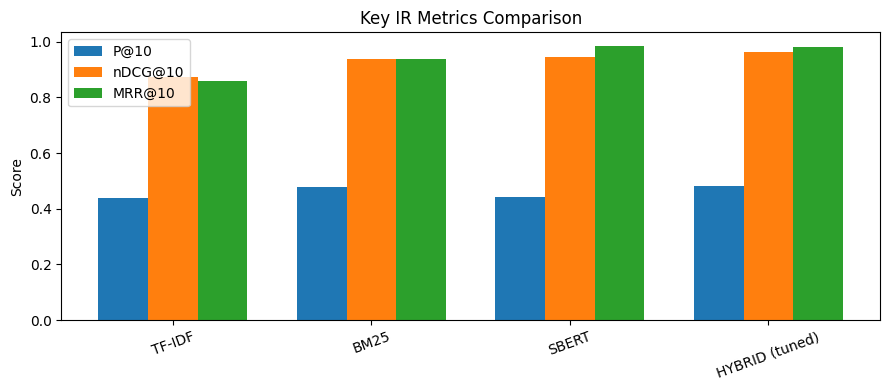

In [28]:
plt.figure(figsize=(7,4))
plt.bar(final_results_df.index, final_results_df[f"nDCG@{k_eval}"].values)
plt.title(f"nDCG@{k_eval} Comparison Across Models")
plt.ylabel(f"nDCG@{k_eval}")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

metrics_to_plot = [f"P@{k_eval}", f"nDCG@{k_eval}", f"MRR@{k_eval}"]
plot_df = final_results_df[metrics_to_plot].copy()

x = np.arange(len(plot_df.index))
width = 0.25

plt.figure(figsize=(9,4))
plt.bar(x - width, plot_df[metrics_to_plot[0]].values, width, label=metrics_to_plot[0])
plt.bar(x,         plot_df[metrics_to_plot[1]].values, width, label=metrics_to_plot[1])
plt.bar(x + width, plot_df[metrics_to_plot[2]].values, width, label=metrics_to_plot[2])
plt.xticks(x, plot_df.index, rotation=20)
plt.ylabel("Score")
plt.title("Key IR Metrics Comparison")
plt.legend()
plt.tight_layout()
plt.show()
